In [1]:
import os
from datetime import datetime, UTC
from pathlib import Path
import pickle

from fractal.loaders.base_loader import LoaderType
from fractal.loaders.thegraph import EthereumUniswapV3Loader

from plot import plot_history_with_pnl
from service import build_observations
from tau_agregator_strategy.avr_tau import TauResetPredict
from tau_agregator_strategy.oracle_strategy import OracleStrategy
from tau_agregator_strategy.tau_ensemble_strategy import TauEnsembleParams, TauEnsembleStrategy

In [2]:
THE_GRAPH_API_KEY = '279f1b788bdf80ec5532277e82d82ca7'

In [9]:
ticker: str = 'ETHUSDT'
pool_address: str = '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8'

token0_decimals, token1_decimals = EthereumUniswapV3Loader(
    THE_GRAPH_API_KEY, loader_type=LoaderType.CSV).get_pool_decimals(pool_address)

start_time = datetime(2024, 1, 5, tzinfo=UTC)
end_time = datetime(2024, 4, 5, tzinfo=UTC)
fidelity = 'hour'

observations = build_observations(ticker, pool_address, THE_GRAPH_API_KEY, start_time, end_time, fidelity=fidelity)

observation0 = observations[0]

Loading cached observations from cache/observations_ETHUSDT_0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8_hour_20240105_20240405.pkl


In [10]:
initial_balance = 1_000_000

ensemble_params = TauEnsembleParams(
    TAU=10, 
    INITIAL_BALANCE=initial_balance
)

TauEnsembleStrategy.token0_decimals = token0_decimals
TauEnsembleStrategy.token1_decimals = token1_decimals
TauEnsembleStrategy.tick_spacing = 60

ensemble_strategy = TauEnsembleStrategy(
    oracul_strategy=OracleStrategy(),
    debug=True,
    params=ensemble_params
)

In [11]:
small = TauResetPredict(tau=5)
big = TauResetPredict(tau=30)

ensemble_strategy.add_model("tau_big", big.avr_tau_reset_predictor, 1)
ensemble_strategy.add_model("tau_small", small.avr_tau_reset_predictor, 1)

entities = ensemble_strategy.get_all_available_entities().keys()
assert all(entity in observation0.states for entity in entities)

In [12]:
 # Running the ensemble strategy
print("Starting ensemble strategy (with one base model)...")
ensemble_result = ensemble_strategy.run(observations)
print("Ensemble strategy results:")
print(ensemble_result.get_default_metrics())

Starting ensemble strategy (with one base model)...
Ensemble strategy results:
StrategyMetrics(accumulated_return=np.float64(0.25767150874346245), apy=np.float64(1.0335175900149867), sharpe=np.float64(2.536966017503577), max_drawdown=np.float64(-0.21465234514949094))


In [14]:
file_name = 'tau_ensemble_result.csv'
ensemble_result.to_dataframe().to_csv(file_name)
print(ensemble_result.to_dataframe().iloc[-1])  # show the last state of the strategy

print("\nDone! Results saved to files tau_ensemble_result.csv and tau_strategy_result.csv")


timestamp                   2024-04-05 00:00:00+00:00
UNISWAP_V3_token0_amount                577113.224169
UNISWAP_V3_token1_amount                   194.707082
UNISWAP_V3_price_init                         3337.33
UNISWAP_V3_price_lower                    3236.903327
UNISWAP_V3_price_upper                    3440.872465
UNISWAP_V3_liquidity            8077681521777645568.0
UNISWAP_V3_cash                           31922.79336
UNISWAP_V3_tvl                       361600998.425148
UNISWAP_V3_volume                      1634894.654534
UNISWAP_V3_fees                           4904.683964
UNISWAP_V3_price                              3331.34
UNISWAP_V3_balance                     1257671.508743
net_balance                            1257671.508743
Name: 2184, dtype: object

Done! Results saved to files tau_ensemble_result.csv and tau_strategy_result.csv


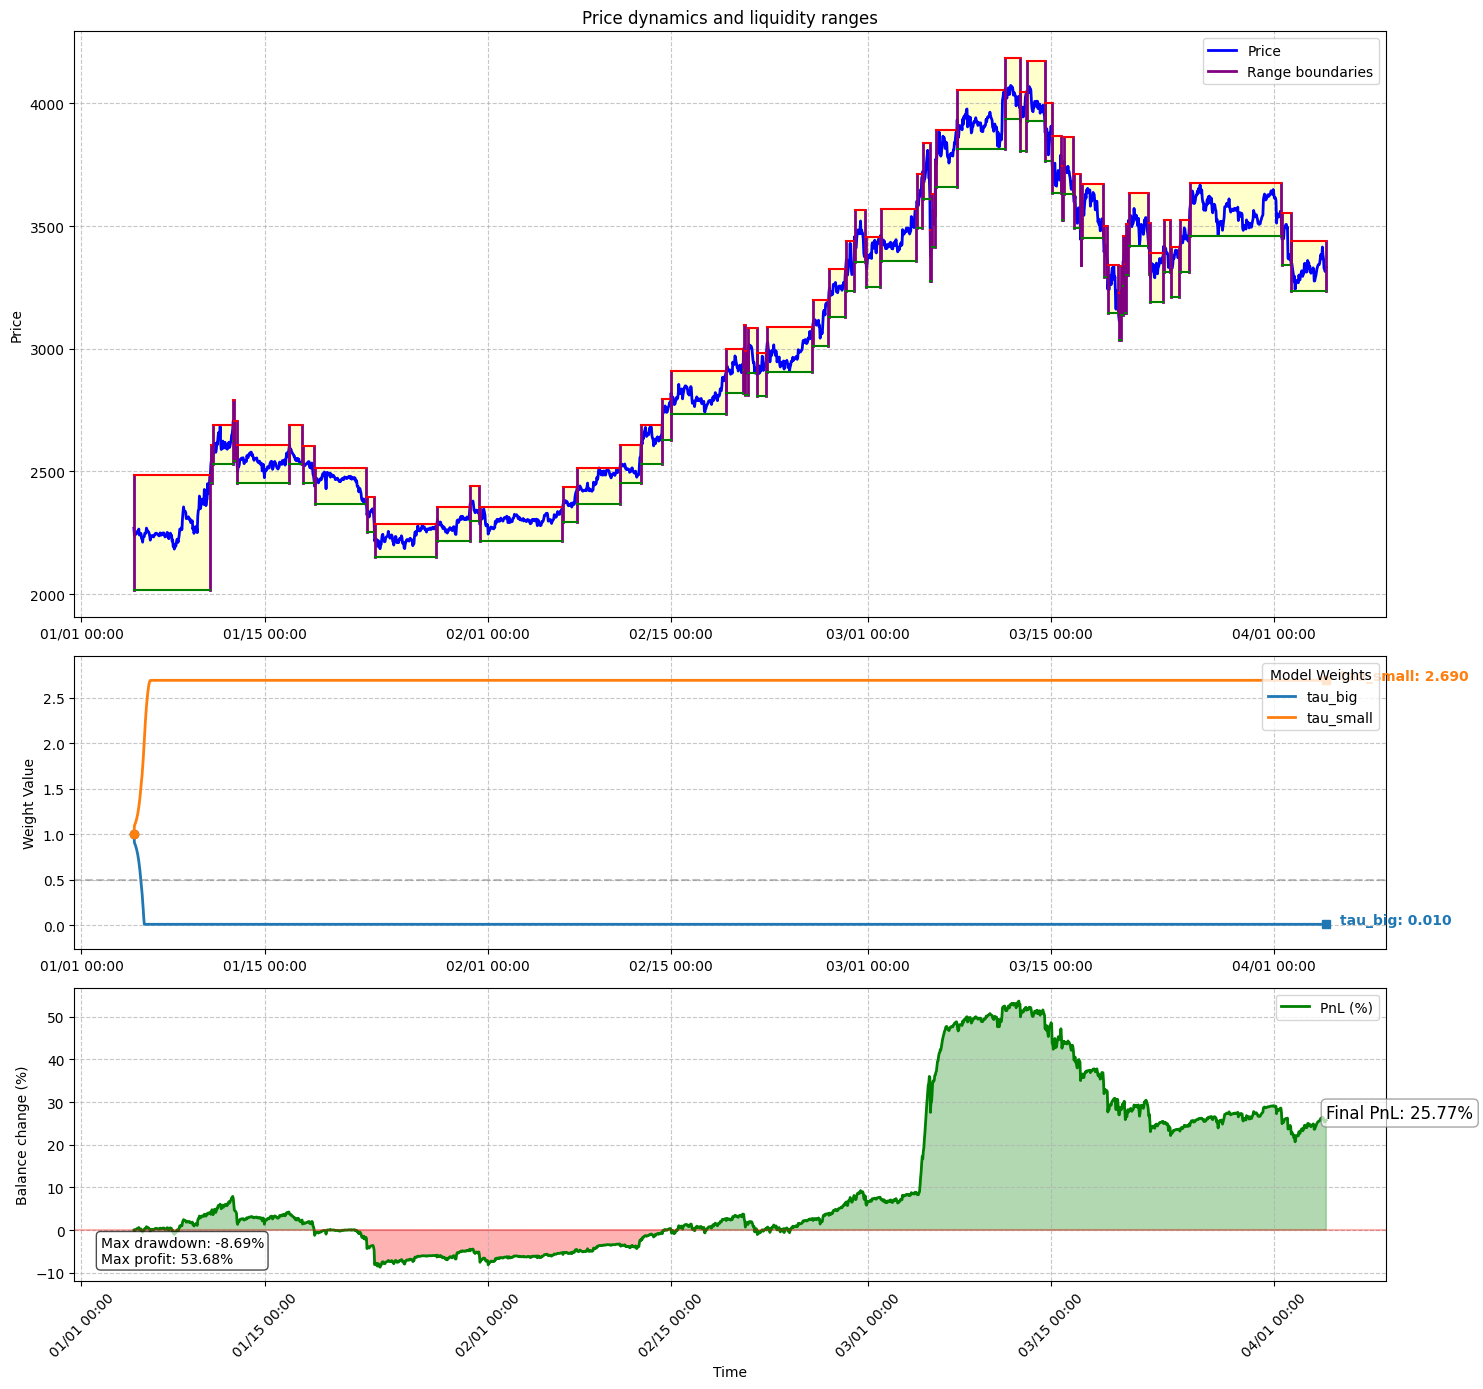

Profitability statistics:
Initial balance: 1000000.00
Final balance: 1257671.51
Change: 25.77%
Maximum drawdown: -8.69%
Maximum profit: 53.68%
Balance volatility: 18.16%
Total fees earned: 2584.01


In [15]:
plot_history_with_pnl(file_name, initial_balance, ensemble_strategy.model_weights)